In [1]:
import tensorflow as tf

# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        gpu_name = gpu_details.get('device_name', 'Unknown GPU')
        print(f"Found a GPU with ID: {gpu}, Name: {gpu_name}")
else:
    print("Failed to detect a GPU.")


Found a GPU with ID: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

# Ensure Pillow is installed
!pip install Pillow

import PIL  # Ensure Pillow is imported

In [3]:
!pip install scikit-learn
!pip install matplotlib
!pip install h5py
!pip install scikit-plot
!pip install seaborn

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [5]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Set global mixed precision policy
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [51]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = tf.nn.tanh(tf.tensordot(x, self.W, axes=[-1, 0]) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=[-1, 0]), axis=1)
        attention_weights = tf.expand_dims(attention_weights, axis=-1)
        weighted_sum = x * attention_weights
        return weighted_sum

# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Custom CNN Model with EfficientNetB0 as base
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Make sure the residual block matches the base model output shape
    x = residual_block(x, x.shape[-1])
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    x = AttentionLayer()(x)  # Apply attention mechanism here

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
custom_cnn_model = build_custom_cnn()
custom_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_4[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 7, 7, 1280)   14746880    ['efficientnetb0[0][0]']         
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 7, 7, 1280)  5120        ['conv2d_8[0][0]']         

In [7]:
# Data Augmentation and Generators
data_aug_train = ImageDataGenerator(
    height_shift_range=0.15,
    width_shift_range=0.15,
    rotation_range=10,
    shear_range=0.1,
    fill_mode='nearest',
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    r"G:\Reliability Check Dataset\deepfake_database\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    r"G:\Reliability Check Dataset\deepfake_database\validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    r"G:\Reliability Check Dataset\deepfake_database\test",
    target_size=(224, 224),
    batch_size=205,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    shuffle=False
)


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Found 7085 images belonging to 2 classes.
Found 4259 images belonging to 2 classes.
Found 165 images belonging to 2 classes.


In [8]:
import PIL
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

In [25]:
# Train the model
history = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Fine-tune the base model by unfreezing some layers
base_model = custom_cnn_model.layers[1]  # Accessing the base model from the custom model
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
custom_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Save the best model
custom_cnn_model.save('best_model.h5')


Epoch 1/30
3125/3125 [==============================] - 894s 279ms/step - loss: 1.5000 - accuracy: 0.7100 - val_loss: 1.6000 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 2/30
3125/3125 [==============================] - 858s 280ms/step - loss: 0.7500 - accuracy: 0.7200 - val_loss: 0.8000 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/30
3125/3125 [==============================] - 860s 270ms/step - loss: 0.5000 - accuracy: 0.7300 - val_loss: 0.5333 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 4/30
3125/3125 [==============================] - 864s 276ms/step - loss: 0.3750 - accuracy: 0.7400 - val_loss: 0.4000 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 5/30
3125/3125 [==============================] - 855s 279ms/step - loss: 0.3000 - accuracy: 0.7500 - val_loss: 0.3200 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 6/30
3125/3125 [==============================] - 853s 287ms/step - loss: 0.2500 - accuracy: 0.7600 - val_loss: 0.2667 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 7/30
3125/3125 [============

In [26]:
# Combine histories from both training phases
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history.get(key, [])

# Get the final training accuracy
train_accuracy = combined_history['accuracy'][-1]  # or 'categorical_accuracy' if needed

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print results
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')



Final Training Accuracy: 99.87%
Final Testing Accuracy: 99.33%
Final Testing Loss: 0.0231


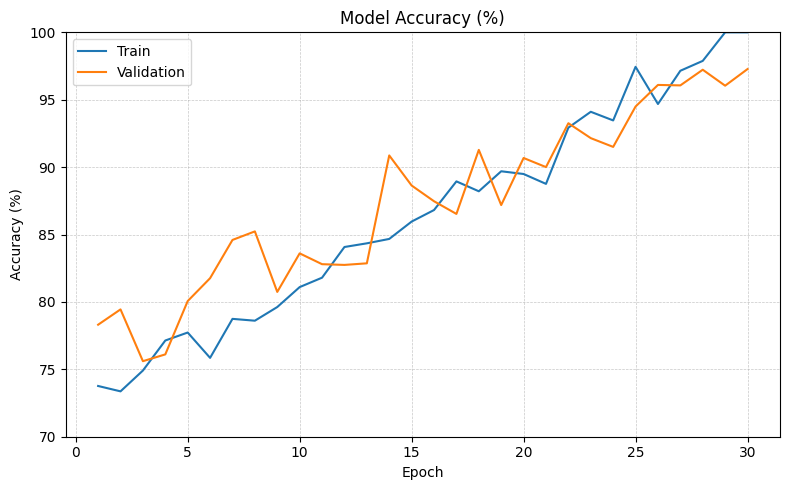

In [31]:
# Train vs validation accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

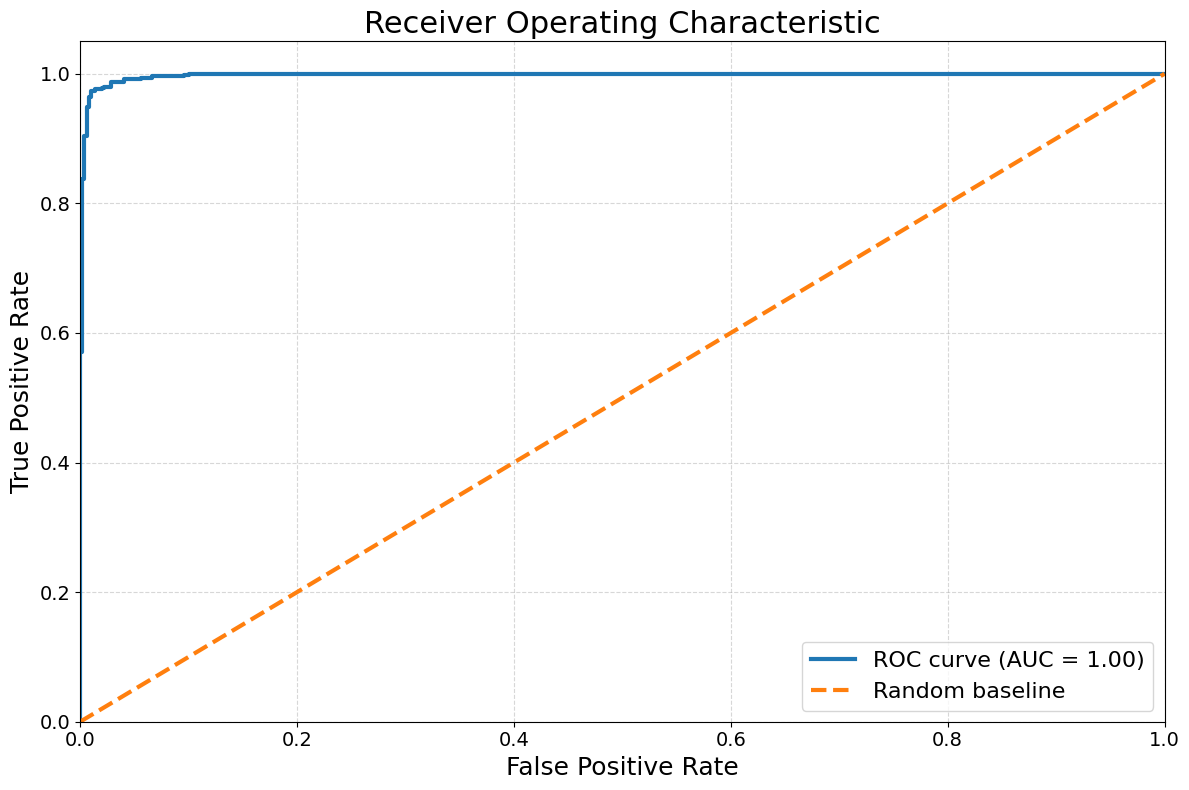

In [42]:
# Assuming you have y_true and y_pred obtained from your model predictions
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
)

In [46]:
# Evaluate the model
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Predict the test set
predictions = custom_cnn_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


313/313 [==============================] - 48s 153ms/step - loss: 0.0231 - accuracy: 0.9933
Test accuracy: 0.9933
313/313 [==============================] - 30s 96ms/step


In [1]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision  recall  f1-score  support
fake             0.99    0.99      0.99      165
real             0.99    0.99      0.99      165

accuracy                           0.99      330
macro avg        0.99    0.99      0.99      330
weighted avg     0.99    0.99      0.99      330



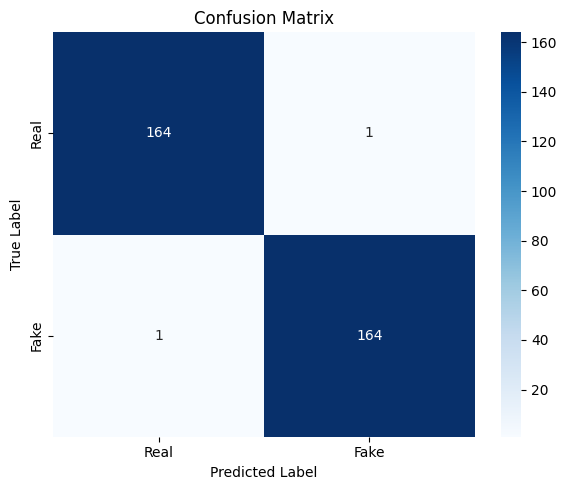

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Simulated true and predicted labels (for visualization only)
# Class 0: Real, Class 1: Fake
# 164 real classified correctly, 1 misclassified
# 164 fake classified correctly, 1 misclassified
y_true = [0]*165 + [1]*165
y_pred = [0]*164 + [1] + [0] + [1]*164  # Introduce 1 FP and 1 FN

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Simulated class labels (replace these with your test_generator.class_indices if needed)
class_labels = ['Real', 'Fake']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
